# Georgian Digital Alphabet Recognition

### Preprocessing
add useful imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
%matplotlib inline

turns a number to a one hot array

In [2]:
def to_one_hot(values: np.ndarray, max: int) -> np.matrix:
    one_hot = np.zeros((values.size, max))
    rows = np.arange(values.size)
    one_hot[rows, values] = 1    

    return one_hot

import image data

In [3]:
import matplotlib.image as im

X_arr = list[np.ndarray]()
Y_arr = list[int]()
num_chars = ord("ჰ") - ord("ა") + 1

for i in range(num_chars):
    char = chr(ord("ა") + i)    # ger character

    file_path_1 = f"data/Letters/{char}"
    file_path_2 = f"data/images/{char}"

    # import first data
    for j, image in enumerate(os.listdir(file_path_1)):
        img_data = im.imread(f"{file_path_1}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)
    
    # import second data
    for j, image in enumerate(os.listdir(file_path_2)):
        img_data = im.imread(f"{file_path_2}/{image}").ravel()

        X_arr.append(np.append(img_data, np.ones(10000 - len(img_data))))
        Y_arr.append(i)

turn list of image values to numpy matrix, values to one_hot vector

In [4]:
X = np.asmatrix(X_arr)
Y = to_one_hot(np.asarray(Y_arr), num_chars)    # convert 33 characters to one_hot array

X.shape, Y.shape

((96897, 10000), (96897, 33))

divide data to train, validation, and test

In [5]:
division_points = (int(X.shape[0] * 0.6), int(X.shape[0] * 0.8))

data = np.append(X, Y, 1)
np.random.shuffle(data)

X = data[:, 0: X.shape[1]]
Y = data[:, X.shape[1]:]

X_train = X[0: division_points[0], :]
Y_train = Y[0: division_points[0], :]

X_valid = X[division_points[0]: division_points[1], :]
Y_valid = Y[division_points[0]: division_points[1], :]

X_test = X[division_points[1]:, :]
Y_test = Y[division_points[1]:, :]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape

((77517, 10000), (77517, 33), (19380, 10000), (19380, 33))

add normalizarion to the three datas seperately

In [6]:
X_train -= X_train.mean(0)
X_valid -= X_valid.mean(0)
X_test -= X_test.mean(0)

##### Reduce dimensions using PCA for data compression reasons
find minimum dimension to reduce data to

start from 0 and raise dimension, until reduced dimension retaines 99% of the original varinace

In [7]:
min_dimension = 0

sigma = (1 / X_train.shape[0]) * X.T * X
u, s, _ = np.linalg.svd(sigma)

dimension_sum = 0
full_sum = np.sum(s)

for k in range(len(s)):
    dimension_sum += s[k]
    variance_retained = dimension_sum / full_sum

    if variance_retained > 0.99:
        min_dimension = k
        break

In [8]:
min_dimension

2344

reduce data

In [9]:
u_reduce = u[:, : min_dimension]

X_train = X_train * u_reduce
X_valid = X_valid * u_reduce
X_test = X_test * u_reduce

X_train.shape, X_valid.shape, X_test.shape

((77517, 2344), (19380, 2344))

### Build a model
build a model using tensorFlow and Keras libraries

In [10]:
from typing import Optional

def get_model(alpha: float, lambd: Optional[float] = 0) -> tf.keras.Sequential:
    # l2 regulizer - sum(square(x))
    from tensorflow.keras.regularizers import l2

    # model with 4 layers
    # Input layer with {min_dimension} nodes
    # 2 hidden layers with "ReLU" activation function and 256 nodes
    # Output layer with "SoftMax" activation function and {num_chars} or 33 layers
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=min_dimension),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(l=lambd)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(l=lambd)),
        tf.keras.layers.Dense(num_chars, activation='softmax', kernel_regularizer=l2(l=lambd))
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=alpha), 
        loss='categorical_crossentropy',    # cost function
        metrics=['accuracy']                # statistics to keep track of
    )

    return model

##### draw the graph of model costs to choose the best alpha

In [13]:
alpha = 0.001   # Manually select the best alpha acording to the cost function graph

model = get_model(alpha)

history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
loss = history.history['loss']

Epoch 1/10
2423/2423 [==============================] - 8s 3ms/step - loss: 1.1887 - accuracy: 0.6746 - val_loss: 0.8117 - val_accuracy: 0.7711
Epoch 2/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.5412 - accuracy: 0.8393 - val_loss: 0.7194 - val_accuracy: 0.8029
Epoch 3/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.3322 - accuracy: 0.8980 - val_loss: 0.7440 - val_accuracy: 0.8161
Epoch 4/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.2334 - accuracy: 0.9274 - val_loss: 0.8223 - val_accuracy: 0.8162
Epoch 5/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.1815 - accuracy: 0.9438 - val_loss: 0.8695 - val_accuracy: 0.8207
Epoch 6/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.1432 - accuracy: 0.9559 - val_loss: 1.0119 - val_accuracy: 0.8176
Epoch 7/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.1314 - accuracy: 0.9606 - val_loss: 1.0471 - val_accuracy:

Text(0.5, 1.0, 'Error vs. Training Epoch')

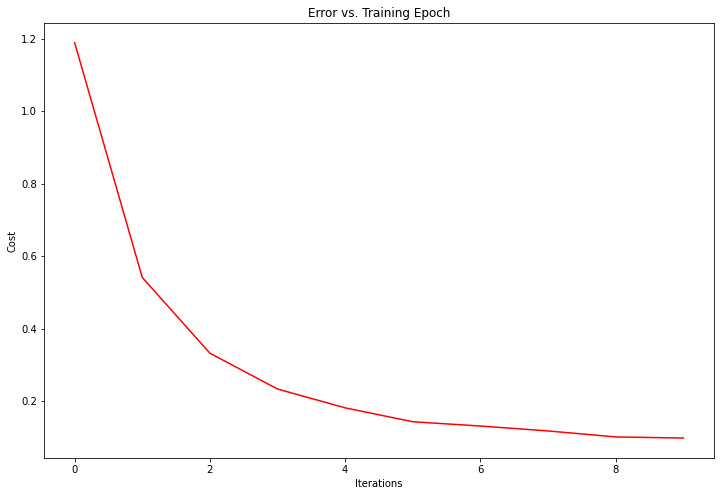

In [14]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(len(loss)), loss, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

##### choose optimal lambda for the model
generate 12 different lambda values (including 0)

In [15]:
lambdas: list[float] = [0]

lambd = 0.0001
while len(lambdas) < 12:
    lambdas.append(lambd)
    
    lambd *= 2

train model on different regularization parameters and choose the one that performes best on cross-validation data

In [16]:
errors_train = np.zeros(len(lambdas))
errors_valid = np.zeros(len(lambdas))
models: list[tf.keras.Sequential] = []

for i, lambd in enumerate(lambdas):
    model = get_model(alpha, lambd)
    history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
    models.append(model)

    train_accuracy = history.history['accuracy'][-1]
    valid_accuracy = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_accuracy
    errors_valid[i] = 1 - valid_accuracy

    print(f"{i + 1} / {len(lambdas)}")

Epoch 1/10
2423/2423 [==============================] - 10s 4ms/step - loss: 1.1878 - accuracy: 0.6731 - val_loss: 0.8260 - val_accuracy: 0.7649
Epoch 2/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.5397 - accuracy: 0.8406 - val_loss: 0.7063 - val_accuracy: 0.8038
Epoch 3/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.3329 - accuracy: 0.8973 - val_loss: 0.7427 - val_accuracy: 0.8115
Epoch 4/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.2346 - accuracy: 0.9270 - val_loss: 0.8471 - val_accuracy: 0.8123
Epoch 5/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.1800 - accuracy: 0.9444 - val_loss: 0.9108 - val_accuracy: 0.8181
Epoch 6/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.1465 - accuracy: 0.9548 - val_loss: 0.9739 - val_accuracy: 0.8243
Epoch 7/10
2423/2423 [==============================] - 8s 3ms/step - loss: 0.1274 - accuracy: 0.9609 - val_loss: 1.0110 - val_accuracy

get the best lambda and the best model acording to the cross-validation accuracy

In [17]:
lambd = lambdas[errors_valid.argmin()]
model = models[errors_valid.argmin()]
lambd

0.0002

Text(0.5, 1.0, 'Error vs. Lambda Value')

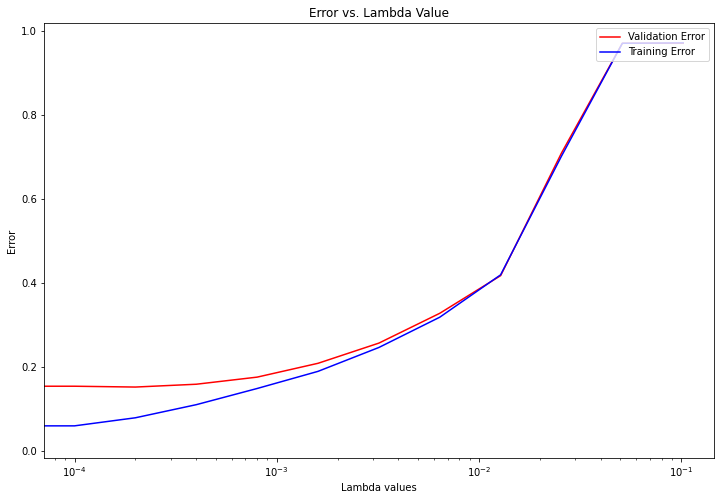

In [18]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.set_xscale('log')
ax.plot(lambdas, errors_valid, 'r', label="Validation Error")
ax.plot(lambdas, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Lambda values')
ax.set_ylabel('Error')
ax.set_title('Error vs. Lambda Value')

##### debug model using learning curves

In [19]:
errors_train = np.zeros(10)
errors_valid = np.zeros(10)

for i in range(10):
    X_train_div = X_train[0: int(((i + 1) * X_train.shape[0]) / 10), :]
    Y_train_div = Y_train[0: int(((i + 1) * Y_train.shape[0]) / 10), :]
    X_valid_div = X_valid[0: int(((i + 1) * X_valid.shape[0]) / 10), :]
    Y_valid_div = Y_valid[0: int(((i + 1) * Y_valid.shape[0]) / 10), :]

    model = get_model(alpha, lambd)
    history = model.fit(X_train_div, Y_train_div, epochs=10, validation_data=(X_valid_div, Y_valid_div))

    train_accuracy = history.history['accuracy'][-1]
    valid_accuracy = history.history['val_accuracy'][-1]

    errors_train[i] = 1 - train_accuracy
    errors_valid[i] = 1 - valid_accuracy

    print(f"{i + 1} / 10")    

Epoch 1/10
243/243 [==============================] - 1s 5ms/step - loss: 2.6380 - accuracy: 0.3596 - val_loss: 1.8336 - val_accuracy: 0.5490
Epoch 2/10
243/243 [==============================] - 1s 4ms/step - loss: 1.1558 - accuracy: 0.7464 - val_loss: 1.7402 - val_accuracy: 0.5888
Epoch 3/10
243/243 [==============================] - 1s 4ms/step - loss: 0.7069 - accuracy: 0.8715 - val_loss: 1.8120 - val_accuracy: 0.6084
Epoch 4/10
243/243 [==============================] - 1s 4ms/step - loss: 0.5155 - accuracy: 0.9312 - val_loss: 1.9297 - val_accuracy: 0.6047
Epoch 5/10
243/243 [==============================] - 1s 4ms/step - loss: 0.4174 - accuracy: 0.9626 - val_loss: 2.0118 - val_accuracy: 0.6042
Epoch 6/10
243/243 [==============================] - 1s 4ms/step - loss: 0.3697 - accuracy: 0.9728 - val_loss: 2.1378 - val_accuracy: 0.6032
Epoch 7/10
243/243 [==============================] - 1s 3ms/step - loss: 0.3398 - accuracy: 0.9810 - val_loss: 2.1715 - val_accuracy: 0.6078
Epoch 

Text(0.5, 1.0, 'Error vs. Data Size')

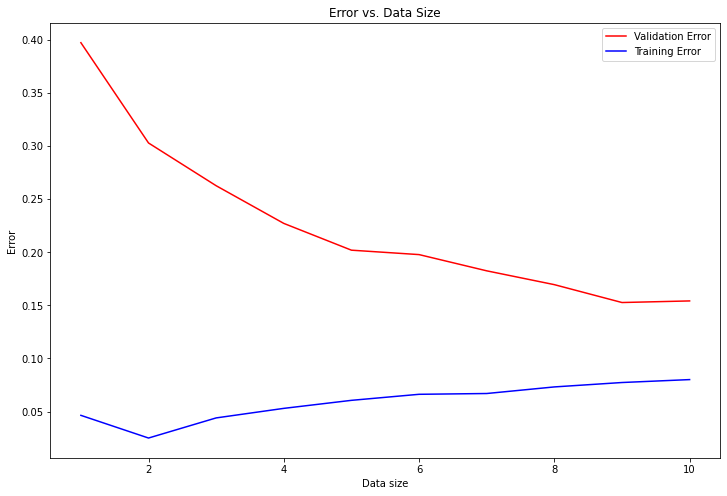

In [20]:
vfig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(10) + 1, errors_valid, 'r', label="Validation Error")
ax.plot(np.arange(10) + 1, errors_train, 'b', label="Training Error")
ax.legend(loc=1)
ax.set_xlabel('Data size')
ax.set_ylabel('Error')
ax.set_title('Error vs. Data Size')

In [21]:
def predict(predictions: np.matrix) -> np.matrix:
    return to_one_hot(np.asarray(predictions.argmax(axis=1)).ravel(), num_chars)

In [22]:
def get_accuracy(model: tf.keras.Sequential, X: np.matrix, Y: np.matrix) -> float:
    return (predict(model.predict(X)) == Y).all(axis=1).mean()

In [25]:
get_accuracy(model, X_test, Y_test)

0.8458204334365325

Save neural network model

In [26]:
model.save("./andria_kilasonia_nn_model.h5")

Save data reduction matrix

In [27]:
np.save('andria_kilasonia_reduce_martix.npy', u_reduce)